<a href="https://colab.research.google.com/github/Kanchanbhale/Charity-Plugin/blob/main/Charity_Evalution_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Imports

In [ ]:
import pandas as pd                     # for data manipulation and analysis

%matplotlib inline
import matplotlib.pyplot as plt        # object-oriented API for embedding plots into applications

import matplotlib                       
import numpy as np                     # used for working with arrays
import missingno as msno               # provides a series of visualisations to understand the presence and distribution of missing data within a pandas dataframe
import altair as alt                   # statistical visualization library
from vega_datasets import data         


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from sklearn import preprocessing

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

import re
from sklearn.base import BaseEstimator, TransformerMixin
import nltk.stem

# Data Set

In [ ]:
df = pd.read_csv('charity_navigator.csv.txt')
df.head()

,Unnamed: 0,category,cause,charityid,mission,tagline
0,0,arts culture humanities,museums,9745,the utah museum of contemporary art advances a...,utah premiere venue for contemporary art
1,1,health,diseases disorders and disciplines,8857,the national mps society exists to find cures ...,support for families research for cure
2,2,health,patient and family support,14464,the ronald mcdonald house of san francisco rmh...,the house that love built
3,3,human services,social services,4177,the mission of the national federation of the ...,live the life you want
4,4,animals,zoos and aquariums,3718,the oldest zoo in texas the fort worth zoo was...,strengthening the bond between humans and the ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  9119 non-null   int64 
 1   category    9119 non-null   object
 2   cause       9119 non-null   object
 3   charityid   9119 non-null   int64 
 4   mission     8654 non-null   object
 5   tagline     8699 non-null   object
dtypes: int64(2), object(4)
memory usage: 427.6+ KB


# Preprocess and Explore Data 

## Uniformative Columns

In [ ]:
print(df.columns)
df.drop(['Unnamed: 0','charityid'], axis=1, inplace=True)     #no. ofcols available and which are dropped 
df.head()

Index(['Unnamed: 0', 'category', 'cause', 'charityid', 'mission', 'tagline'], dtype='object')


,category,cause,mission,tagline
0,arts culture humanities,museums,the utah museum of contemporary art advances a...,utah premiere venue for contemporary art
1,health,diseases disorders and disciplines,the national mps society exists to find cures ...,support for families research for cure
2,health,patient and family support,the ronald mcdonald house of san francisco rmh...,the house that love built
3,human services,social services,the mission of the national federation of the ...,live the life you want
4,animals,zoos and aquariums,the oldest zoo in texas the fort worth zoo was...,strengthening the bond between humans and the ...


In [ ]:
len(df['cause'].unique())

37

## Missing Rows

### Visualize Missing Rows

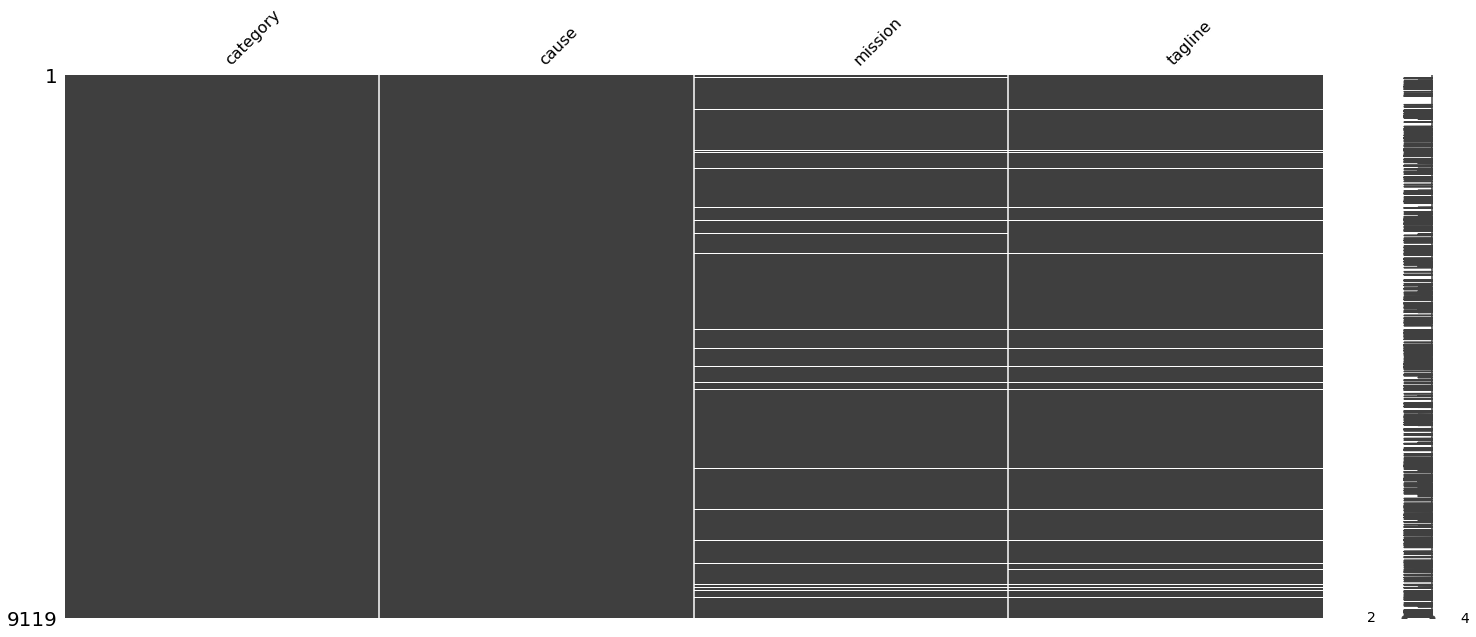

In [ ]:
msno.matrix(df)

### Drop Missing Rows

In [ ]:
## Drop Empty Rows
df.dropna(axis=0, how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8638 entries, 0 to 9118
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  8638 non-null   object
 1   cause     8638 non-null   object
 2   mission   8638 non-null   object
 3   tagline   8638 non-null   object
dtypes: object(4)
memory usage: 337.4+ KB


## Check Class Balance

We can upsample to handle the class imbalance or use an algorithm (e.g.: Tree-based) that is insensitve to the class imbalance.

In [ ]:
pic = pd.DataFrame(df['category'].value_counts())

In [ ]:
pic['name'] = pic.index.values.tolist()

In [ ]:
pic                  #add visualization in report and ppt

,category,name
human services,2430,human services
arts culture humanities,1228,arts culture humanities
health,894,health
community development,807,community development
education,671,education
international,626,international
animals,485,animals
religion,465,religion
environment,447,environment
human and civil rights,370,human and civil rights


In [ ]:
source = pic

bars = alt.Chart(source).mark_bar().encode(
     x='category:Q',
     y=alt.Y(
        "name:O",
        sort=alt.EncodingSortField(
            field="category",  # The field to use for the sort
            #op="sum",  # The operation to run on the field prior to sorting
            order="ascending"  # The order to sort in
        )
    )
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='category:Q'
)

(bars + text).properties(height=200)    

alt.LayerChart(...)

# Subset Data for Analysis

Use a subset of the data for analysis

In [ ]:
target_lst = ['museums', 'united ways' ,'development and relief services',
              'advocacy and education','children and family services']

In [ ]:
df = df.loc[df['cause'].isin(target_lst)]

# Extraction Features

## Encode Target 


In [ ]:
target = 'cause'

le = preprocessing.LabelEncoder()
le.fit(df[target])
#print(le.classes_)
df['target'] = le.transform(df[target]) 
df['target'].value_counts()[0:10]

3    397
4    395
2    388
0    370
1    356
Name: target, dtype: int64

## Apply Custom Analyzer

The data set contains many mention to year and organization was founded, which we will not be important for matching news articles. All numbers were remove with regex as a preprocessing step.

In addition, many words appear duplicated due to variations on the ending of the word. Endings were stemmed using  Snowball stemming for NLTK package

stop : 9514
doc freq: 6780
remove number: 6486
stem : 4388

### Aggregate Text Fields

In [ ]:
# merge text to create a document
df['corpus'] = df.mission + df.tagline + df.category
# drop other columns, convenience
df.drop(['mission', 'tagline', 'category'], axis=1, inplace=True)

df.head()

,cause,target,corpus
0,museums,3,the utah museum of contemporary art advances a...
6,development and relief services,2,founded in 1999 the mission of medical mission...
7,children and family services,1,guided by the wisdom and values of our traditi...
14,advocacy and education,0,founded in 1971 the national partnership for w...
18,united ways,4,the united way of monongalia and preston count...


In [ ]:
df.corpus[0]

'the utah museum of contemporary art advances and elevates the community of contemporary arts and culture establishing utah as leading voice for the spirit of innovation experimentation and dialogue surrounding the issues of our timeutah premiere venue for contemporary artarts culture humanities'

In [ ]:
df.shape

(1906, 3)

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.corpus)
print(len(vectorizer.get_feature_names()))

12456


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df.shape

(1906, 3)

### Stem Words and Filter Integers

In [ ]:
# preprocessing step 
def drop_integers(s):
    return re.sub(r'\d+', '', s)

In [ ]:
# stemmer
english_stemmer = nltk.stem.SnowballStemmer('english')       #visualization

def stemmer(doc):
    return [porter_stemmer.stem(w) for w in analyzer(doc)]

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        # will need to rewrite if pickled - due to lambda
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])
   

In [ ]:
vectorizer_s = StemmedCountVectorizer(min_df=5,  preprocessor=drop_integers,
                                      analyzer='word', stop_words='english') 

X = vectorizer_s.fit_transform(df.corpus)
print(X.shape)
print(vectorizer_s.get_feature_names()[0:20])

(1906, 1867)
['abandon', 'abil', 'abl', 'abort', 'abroad', 'abus', 'abusehuman', 'academ', 'academi', 'accept', 'access', 'acclaim', 'accomplish', 'accord', 'account', 'accredit', 'accur', 'achiev', 'aclu', 'acquir']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
vectorizer = TfidfTransformer()
X_tfidf = vectorizer.fit_transform(X)    #add vis. add to results, print words
print(X_tfidf.shape)
print(X_tfidf)

(1906, 1867)
  (0, 1807)	0.1541249284587658
  (0, 1786)	0.2267533011623153
  (0, 1775)	0.4769691023979484
  (0, 1664)	0.19650988684357845
  (0, 1603)	0.19506506787097247
  (0, 1331)	0.18108536782820472
  (0, 1164)	0.10003609683356515
  (0, 1009)	0.1302599890735798
  (0, 950)	0.12482613414500161
  (0, 917)	0.13521390822121357
  (0, 858)	0.07682922351657642
  (0, 628)	0.2205993357810796
  (0, 598)	0.13124899241125457
  (0, 547)	0.2434036022307188
  (0, 470)	0.21786933432061167
  (0, 408)	0.1778105901141414
  (0, 364)	0.46520864539121537
  (0, 321)	0.06170245235687211
  (0, 112)	0.17739847719972426
  (0, 111)	0.22546613864971732
  (0, 39)	0.119907083113257
  (1, 1854)	0.18319507138581564
  (1, 1776)	0.19800917495020406
  (1, 1774)	0.13408411214334748
  (1, 1758)	0.178097721501643
  :	:
  (1905, 1005)	0.08583886857036259
  (1905, 971)	0.1590118035975813
  (1905, 917)	0.08080120299115248
  (1905, 893)	0.21800322753312967
  (1905, 888)	0.11682219765635363
  (1905, 884)	0.07421949041715067
  

# Create Train and Test Sets

Dont forget to shuffle the data

In [ ]:
seed = 2
X_train, X_test, y_train, y_test = train_test_split(df.corpus, df.target,
                                                    test_size=0.20,
                                                    random_state=seed, 
                                                    shuffle=True)

In [ ]:
X_train

8519    founded in 2000 common cause education fund cc...
1432    after the adoption of their first daughter sha...
995     bishop museum mission since founding has been ...
3770    the museum of craft and design mcd develops an...
7722    united way of aiken county lives by mobilizing...
                              ...                        
7551    raices refugee immigrant center for education ...
7774    agape international missions aim has served in...
2542    founded in 1982 by constitutional attorney and...
2718    infant crisis services provides life sustainin...
5843    founded in 1977 the american committee for the...
Name: corpus, Length: 1524, dtype: object

# Define Pipelines

In [ ]:
NB_pipeline = Pipeline([
    ('vect', StemmedCountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB(alpha=0.01)),
])

LR_pipeline = Pipeline([
    ('vect', StemmedCountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(random_state=0, solver='lbfgs',
                               multi_class='multinomial')),
])

SVC_pipeline = Pipeline([
    ('vect', StemmedCountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()),
])

RF_pipeline = Pipeline([
    ('vect', StemmedCountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=100, 
                                   max_depth=2)),
])

SGD_pipeline = Pipeline([
    ('vect', StemmedCountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3)),        
])

In [ ]:
## naive bayes
NB_pipeline.fit(X_train, y_train)
predictionNB = NB_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, predictionNB)))
print('\n CONFUSION MATRIX')
print(confusion_matrix(y_test, predictionNB))
print('\nCLASSIFICATION REPORT')
print(classification_report(y_test, predictionNB))


Test accuracy is 0.9528795811518325

 CONFUSION MATRIX
[[55  3  1  1  0]
 [ 0 70  9  0  1]
 [ 2  0 87  0  1]
 [ 0  0  0 79  0]
 [ 0  0  0  0 73]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        60
           1       0.96      0.88      0.92        80
           2       0.90      0.97      0.93        90
           3       0.99      1.00      0.99        79
           4       0.97      1.00      0.99        73

    accuracy                           0.95       382
   macro avg       0.96      0.95      0.95       382
weighted avg       0.95      0.95      0.95       382



In [ ]:
predictionNB

array([3, 3, 1, 1, 1, 3, 3, 1, 1, 0, 0, 2, 0, 2, 0, 4, 3, 1, 0, 1, 1, 2,
       3, 4, 3, 3, 1, 3, 3, 1, 1, 3, 2, 4, 2, 0, 2, 0, 1, 2, 1, 2, 2, 4,
       2, 2, 4, 0, 4, 2, 2, 4, 2, 1, 4, 4, 0, 0, 0, 4, 1, 3, 4, 2, 0, 2,
       4, 2, 4, 4, 2, 1, 0, 4, 2, 3, 0, 1, 4, 4, 1, 4, 4, 2, 4, 2, 1, 1,
       1, 3, 3, 2, 0, 2, 1, 3, 3, 2, 0, 0, 4, 0, 2, 1, 2, 3, 4, 2, 3, 2,
       0, 2, 4, 2, 2, 4, 4, 2, 2, 2, 4, 2, 4, 2, 3, 1, 3, 0, 4, 3, 1, 3,
       0, 1, 2, 4, 2, 4, 1, 2, 1, 0, 0, 2, 3, 1, 4, 0, 2, 1, 3, 3, 3, 0,
       3, 1, 0, 2, 4, 3, 0, 3, 0, 3, 3, 0, 0, 3, 3, 4, 4, 2, 2, 2, 1, 3,
       1, 1, 1, 4, 3, 3, 0, 3, 2, 3, 4, 0, 4, 0, 2, 3, 3, 1, 3, 2, 3, 2,
       2, 2, 2, 1, 3, 4, 3, 1, 2, 1, 2, 3, 4, 0, 0, 1, 2, 2, 2, 2, 2, 2,
       1, 4, 3, 3, 4, 3, 0, 3, 0, 1, 2, 4, 2, 2, 4, 3, 3, 3, 4, 4, 4, 2,
       3, 2, 0, 2, 1, 2, 4, 3, 0, 2, 1, 1, 4, 2, 4, 1, 2, 1, 0, 1, 2, 1,
       1, 2, 0, 1, 4, 3, 2, 1, 1, 4, 2, 0, 3, 2, 4, 1, 2, 4, 2, 1, 2, 4,
       3, 1, 3, 2, 4, 0, 3, 1, 1, 3, 4, 2, 0, 2, 4,

In [ ]:
## Logistic Regression
LR_pipeline.fit(X_train, y_train)
predictionLR = LR_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,predictionLR)))
print('\nCONFUSION MATRIX')
print(confusion_matrix(y_test, predictionLR))
print('\nCLASSIFICATION REPORT')
print(classification_report(y_test, predictionLR))


Test accuracy is 0.9581151832460733

CONFUSION MATRIX
[[59  0  1  0  0]
 [ 0 68 12  0  0]
 [ 0  2 87  0  1]
 [ 0  0  0 79  0]
 [ 0  0  0  0 73]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.97      0.85      0.91        80
           2       0.87      0.97      0.92        90
           3       1.00      1.00      1.00        79
           4       0.99      1.00      0.99        73

    accuracy                           0.96       382
   macro avg       0.97      0.96      0.96       382
weighted avg       0.96      0.96      0.96       382



In [ ]:
## Suport Vector
SVC_pipeline.fit(X_train, y_train)
predictionSVC = SVC_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,predictionSVC)))
print('\nCONFUSION MATRIX')
print(confusion_matrix(y_test, predictionSVC))
print('\nCLASSIFICATION REPORT')
print(classification_report(y_test, predictionSVC))


Test accuracy is 0.9659685863874345

CONFUSION MATRIX
[[60  0  0  0  0]
 [ 0 71  9  0  0]
 [ 0  3 86  0  1]
 [ 0  0  0 79  0]
 [ 0  0  0  0 73]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.96      0.89      0.92        80
           2       0.91      0.96      0.93        90
           3       1.00      1.00      1.00        79
           4       0.99      1.00      0.99        73

    accuracy                           0.97       382
   macro avg       0.97      0.97      0.97       382
weighted avg       0.97      0.97      0.97       382



In [ ]:
##Stochastic Gradient Descent
SGD_pipeline.fit(X_train,y_train)
predictionSGD = SGD_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, predictionSGD)))
print('\nCONFUSION MATRIX')
print(confusion_matrix(y_test, predictionSGD))
print('\nCLASSIFICATION REPORT')
print(classification_report(y_test, predictionSGD))


Test accuracy is 0.9659685863874345

CONFUSION MATRIX
[[59  1  0  0  0]
 [ 0 72  8  0  0]
 [ 0  3 86  0  1]
 [ 0  0  0 79  0]
 [ 0  0  0  0 73]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.95      0.90      0.92        80
           2       0.91      0.96      0.93        90
           3       1.00      1.00      1.00        79
           4       0.99      1.00      0.99        73

    accuracy                           0.97       382
   macro avg       0.97      0.97      0.97       382
weighted avg       0.97      0.97      0.97       382



In [ ]:
# random forest
RF_pipeline.fit(X_train,y_train)
predictionRF = RF_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, predictionRF)))
print('\nCONFUSION MATRIX')
print(confusion_matrix(y_test, predictionRF))
print('\nCLASSIFICATION REPORT')
print(classification_report(y_test, predictionRF))

Test accuracy is 0.7879581151832461

CONFUSION MATRIX
[[60  0  0  0  0]
 [11 32 15  2 20]
 [17  2 57  2 12]
 [ 0  0  0 79  0]
 [ 0  0  0  0 73]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        60
           1       0.94      0.40      0.56        80
           2       0.79      0.63      0.70        90
           3       0.95      1.00      0.98        79
           4       0.70      1.00      0.82        73

    accuracy                           0.79       382
   macro avg       0.81      0.81      0.77       382
weighted avg       0.82      0.79      0.77       382



In [ ]:
results = {'Algorithm': ['naive_bayes', 'logistic_regression','support_vector','gradient_descent','random_forest' ],
           'Accuracy': [0.95,0.96,0.96,0.97,0.81] }
res_df = pd.DataFrame(results)
res_df.head()                       

,Algorithm,Accuracy
0,naive_bayes,0.95
1,logistic_regression,0.96
2,support_vector,0.96
3,gradient_descent,0.97
4,random_forest,0.81


In [ ]:
res_df.info()            

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Algorithm  5 non-null      object 
 1   Accuracy   5 non-null      float64
dtypes: float64(1), object(1)
memory usage: 208.0+ bytes


In [ ]:
#Data Type	Shorthand Code	Description
#quantitative	Q	a continuous real-valued quantity
#ordinal	O	a discrete ordered quantity
#nominal	N	a discrete unordered category
#temporal	T	a time or date value

source = res_df

bars = alt.Chart(source).mark_bar().encode(
     x='Accuracy:Q',
     y=alt.Y("Algorithm:N",
             sort=alt.EncodingSortField(
                 field="Accuracy",  # The field to use for the sort
                 order="descending"  # The order to sort in
             )
            )
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Accuracy:Q'
)

(bars + text).properties(height=200)

alt.LayerChart(...)

# Configure Grid Search

## Define Grid Parameters

In [ ]:
# Set grid search params
param_range = [1, 3]

grid_params_mnb = [{
    'vect__ngram_range': [(1, 1)],
    'clf__fit_prior': (True, False),
}] 


grid_params_svm = [{
    'vect__ngram_range': [(1, 1)],
    'clf__C': param_range,
}]

grid_params_sgd = [{
    'vect__ngram_range': [(1, 1)],
    'clf__penalty': ['l2'],
    'clf__loss' : ('hinge'),
    'clf__alpha': (1e-2, 1e-3),
}]

## Initialize Grid 

In [ ]:
# Construct grid objects

gs_mnb = GridSearchCV(
    estimator=pipe_mnb,
    param_grid=grid_params_mnb,
    scoring='accuracy',
    cv=10) 

gs_svm = GridSearchCV(
    estimator=pipe_svm,
    param_grid=grid_params_svm,
    scoring='accuracy',
    cv=10)

gs_sgd = GridSearchCV(
    estimator=pipe_sgd,
    param_grid=grid_params_sgd,
    scoring='accuracy',
    cv=10, 
    n_jobs=jobs)

# List of pipelines for ease of iteration
#grids = [gs_mnb, gs_svm, gs_sgd]
grids = [gs_sgd]

# Dictionary of pipelines and classifier types for ease of reference
#grid_dict = {0: 'Multinomial Naive Bayes', 1: 'Support Vector Machine', 
#             2: 'Stocastic Gradient Descent'}

grid_dict = {0: 'Stocastic Gradient Descent'}

NameError: ignored

# Build Model and Evaluate Performance 

In [ ]:
# Fit the grid search objects

X_train, X_test, y_train, y_test = train_test_split(df.corpus, df.target, test_size=0.20, random_state=seed)

print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params 
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
#dump_file = 'best_gs_pipeline.pkl'
#joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...


NameError: ignored

TESTING ARBITRARY ARTICLE 

In [ ]:
pip install newspaper3k

In [ ]:
import nltk
nltk.download('punkt')
from newspaper import Article
article = Article('https://timesofindia.indiatimes.com/city/kochi/revenue-from-museum-zoo-crosses-rs-1-crore/articleshow/88673531.cms')
article.download()
article.parse()
article.nlp()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
article.keywords

['museum',
 'collection',
 'week',
 'visits',
 'crore',
 'crosses',
 'rs',
 'zoo',
 'parking',
 'revenue',
 'visitors']

In [ ]:
article.text

'Thiruvananthapuram: The revenue collection in the museum and zoo , which was badly hit by Covid-19, bounced back to normal with the authorities recording Rs 1 cr collection in two-and-a-half months.Peak turnout during the festive season brought good money for the museum and zoo as the daily collection, which hovered around Rs 1-2 lakh, jumped to Rs 4 lakhs towards the last week of December. The authorities recorded a cumulative collection of Rs 1.01 crore by the end of December.“In 2020, for an entire year we could collect only Rs 1.4 crore. This year, we crossed 1 crore in just around 50 days,” museum and zoo director said Abu S.The revenue collection from parking also increased considerably with many visitors opting for private vehicles and parking of vehicles on museum compounds yielded good revenue. With RKV Road being closed for parking as part of Smart City works, the museum compound was the much sought after parking zone for many visitors.While the city zoo is the favoured spot

In [ ]:
article.summary

'Thiruvananthapuram: The revenue collection in the museum and zoo , which was badly hit by Covid-19, bounced back to normal with the authorities recording Rs 1 cr collection in two-and-a-half months.Peak turnout during the festive season brought good money for the museum and zoo as the daily collection, which hovered around Rs 1-2 lakh, jumped to Rs 4 lakhs towards the last week of December.\nThe authorities recorded a cumulative collection of Rs 1.01 crore by the end of December.“In 2020, for an entire year we could collect only Rs 1.4 crore.\nThis year, we crossed 1 crore in just around 50 days,” museum and zoo director said Abu S.The revenue collection from parking also increased considerably with many visitors opting for private vehicles and parking of vehicles on museum compounds yielded good revenue.\nIn October last week, the daily collection from the art gallery, the museum and the zoo had picked up from Rs 64,310 to Rs 1,69,075 in less than a week.\nThe museum was equipped wit

create data frame for sumary, test on clasifier for this one article. 

In [ ]:
my_data = np.array([[article.text, '0'], [article.summary, '1'], [article.summary, '2']])
test_column_names = ['corpus', 'target']
test_df = pd.DataFrame(data=my_data, columns=test_column_names)
print(test_df)

                                              corpus target
0  Thiruvananthapuram: The revenue collection in ...      0
1  Thiruvananthapuram: The revenue collection in ...      1
2  Thiruvananthapuram: The revenue collection in ...      2


In [ ]:
#library that contains punctuation
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
#defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
test_df['clean_corpus']= test_df['corpus'].apply(lambda x:remove_punctuation(x))
test_df.head()

,corpus,target,clean_corpus
0,Thiruvananthapuram: The revenue collection in ...,0,Thiruvananthapuram The revenue collection in t...
1,Thiruvananthapuram: The revenue collection in ...,1,Thiruvananthapuram The revenue collection in t...
2,Thiruvananthapuram: The revenue collection in ...,2,Thiruvananthapuram The revenue collection in t...


In [ ]:
test_df.corpus[2]

'Thiruvananthapuram: The revenue collection in the museum and zoo , which was badly hit by Covid-19, bounced back to normal with the authorities recording Rs 1 cr collection in two-and-a-half months.Peak turnout during the festive season brought good money for the museum and zoo as the daily collection, which hovered around Rs 1-2 lakh, jumped to Rs 4 lakhs towards the last week of December.\nThe authorities recorded a cumulative collection of Rs 1.01 crore by the end of December.“In 2020, for an entire year we could collect only Rs 1.4 crore.\nThis year, we crossed 1 crore in just around 50 days,” museum and zoo director said Abu S.The revenue collection from parking also increased considerably with many visitors opting for private vehicles and parking of vehicles on museum compounds yielded good revenue.\nIn October last week, the daily collection from the art gallery, the museum and the zoo had picked up from Rs 64,310 to Rs 1,69,075 in less than a week.\nThe museum was equipped wit

In [ ]:
test_df.clean_corpus[2]

'Thiruvananthapuram The revenue collection in the museum and zoo  which was badly hit by Covid19 bounced back to normal with the authorities recording Rs 1 cr collection in twoandahalf monthsPeak turnout during the festive season brought good money for the museum and zoo as the daily collection which hovered around Rs 12 lakh jumped to Rs 4 lakhs towards the last week of December\nThe authorities recorded a cumulative collection of Rs 101 crore by the end of December“In 2020 for an entire year we could collect only Rs 14 crore\nThis year we crossed 1 crore in just around 50 days” museum and zoo director said Abu SThe revenue collection from parking also increased considerably with many visitors opting for private vehicles and parking of vehicles on museum compounds yielded good revenue\nIn October last week the daily collection from the art gallery the museum and the zoo had picked up from Rs 64310 to Rs 169075 in less than a week\nThe museum was equipped with attractive and informativ

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(test_df.clean_corpus, test_df.target,
                                                    test_size=1,)

In [ ]:
## Suport Vector
SVC_pipeline.fit(X_train, y_train)
predictionSVC = SVC_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,predictionSVC)))
print('\nCONFUSION MATRIX')
print(confusion_matrix(y_test, predictionSVC))
print('\nCLASSIFICATION REPORT')
print(classification_report(y_test, predictionSVC))

Test accuracy is 0.0

CONFUSION MATRIX
[[0 0]
 [1 0]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
predictionSVC

array(['1'], dtype=object)

In [ ]:
X_test

2    Thiruvananthapuram The revenue collection in t...
Name: clean_corpus, dtype: object

In [ ]:
df1 = pd.read_csv('webdata.csv')

In [ ]:
df1.head()

,Number,Category,Content
0,1,Animals,The world's last male white rhino is almost ce...
1,1,Animals,Animal welfare for travelers: How to enjoy wil...
2,1,Animals,New standards in animal welfare raise new issu...
3,1,Animals,Never mind CCTV in slaughterhouses - we need t...
4,1,Animals,"China: Yulin Dog Meat Festival Canceled, Say A..."


In [ ]:
df1.Category[69]

'Education'

In [ ]:
df1.Content[69]

'Where College Students Can Find Emergency Money and HousingCollege students without a financial safety net are in a tough spot when unexpected costs arise.  "The chances their parents can pick up the bill are not as high," says Sara Goldrick-Rab, a professor at Temple University in Philadelphia and founder of the Wisconsin HOPE Lab, a research center at the University of Wisconsin-Madison. "It\'s not for lack of families wanting to; they don\'t have it."  A 2018 national survey led by Goldrick-Rab found that over a third of university students out of over 20,000 surveyed said they were food insecure, or had had limited or uncertain access to food in the previous 30 days. And 36 percent of those students said they were housing insecure in the last year, which means they had trouble paying housing bills or had to move frequently.  Recognizing that a financial crisis can force a student to withdraw from classes, about three-quarters of colleges and other postsecondary schools offer some 

In [ ]:
my_data1 = np.array([[df1.Content[69], '0'], [df1.Content[72], '1'], [df1.Content[76], '2']])
test_column_names1 = ['corpus', 'target']
test_df1 = pd.DataFrame(data=my_data1, columns=test_column_names1)
print(test_df1)

                                              corpus target
0  Where College Students Can Find Emergency Mone...      0
1  Board of Education candidate Clare Weil: Educa...      1
2  Our say: Community college scholarship program...      2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(test_df1.corpus, test_df1.target,
                                                    test_size=1,)

In [ ]:
SVC_pipeline.fit(X_train, y_train)
predictionSVC = SVC_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,predictionSVC)))
print('\nCONFUSION MATRIX')
print(confusion_matrix(y_test, predictionSVC))
print('\nCLASSIFICATION REPORT')
print(classification_report(y_test, predictionSVC))

Test accuracy is 0.0

CONFUSION MATRIX
[[0 1]
 [0 0]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
predictionSVC

array(['2'], dtype=object)

# Testing on random data

> 1. Webdataset (200 points) 
2. Random link 
3. Real time 




In [5]:
import pandas
# load the dataset
dataset = pandas.read_csv('webdata.csv')
dataset.head()

,Number,Category,Content
0,1,Animals,The world's last male white rhino is almost ce...
1,1,Animals,Animal welfare for travelers: How to enjoy wil...
2,1,Animals,New standards in animal welfare raise new issu...
3,1,Animals,Never mind CCTV in slaughterhouses - we need t...
4,1,Animals,"China: Yulin Dog Meat Festival Canceled, Say A..."


In [9]:
#Fetch wordcount for each abstract
dataset['word_count'] = dataset['Content'].apply(lambda x: len(str(x).split(" ")))
dataset[['Content','word_count']].head()

,Content,word_count
0,The world's last male white rhino is almost ce...,1390
1,Animal welfare for travelers: How to enjoy wil...,1147
2,New standards in animal welfare raise new issu...,1713
3,Never mind CCTV in slaughterhouses - we need t...,1450
4,"China: Yulin Dog Meat Festival Canceled, Say A...",680


In [10]:
##Descriptive statistics of word counts
dataset.word_count.describe()

count     220.000000
mean      751.122727
std       472.000115
min        29.000000
25%       470.500000
50%       672.500000
75%      1000.250000
max      2850.000000
Name: word_count, dtype: float64

In [12]:
#Identify common words
freq = pandas.Series(' '.join(dataset['Content']).split()).value_counts()[:20]
freq

the     7833
and     4626
of      4559
to      4501
a       3070
in      3068
for     1639
that    1618
is      1450
on      1113
The     1054
are      943
with     904
as       859
at       777
by       712
from     710
have     691
be       678
was      625
dtype: int64

In [13]:
#Identify uncommon words
freq1 =  pandas.Series(' '.join(dataset 
         ['Content']).split()).value_counts()[-20:]
freq1

inimitable        1
"Freedom          1
Coeli,            1
Murphy/The        1
Rachana           1
provider.         1
judgmental        1
'comedian'        1
Affairs),         1
71                1
parallel.         1
freedoms          1
alive,            1
weaken            1
raging            1
two-week          1
underground       1
working-age       1
Jaggar            1
organization,"    1
dtype: int64

In [20]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
stem = PorterStemmer()
word = "inversely"
print("stemming:",stem.stem(word))
print("lemmatization:", lem.lemmatize(word, "v"))

stemming: invers
lemmatization: inversely


In [23]:
# Libraries for text preprocessing
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

In [24]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

In [43]:
corpus = []
for i in range(0, 200):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', dataset['Content'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [44]:
#View corpus item
corpus[3]

'never mind cctv slaughterhouse need end meat dairy industry altogetherit announced week slaughterhouse england install cctv camera government move try improve animal welfare uk farm lover animal think would thrilled news instead help continue wonder earth killing animal first place question whether caught camera went vegan half year ago much shock turkish family brought kofte like meatball et borek pastry meat inside homemade kebab grandparent grew small village cyprus could rarely afford luxury meat left war torn country uk worked year low paid job began eat meat dish meat luxury would choose give luxury let start obvious argument animal welfare measure put camera slaughterhouse might mean something process raising animal kill cruel government claim camera help uphold animal welfare law apparently protective law farm animal allowed overfed leg break carrying weight kept crammed shed barely seeing shred natural daylight life live knee deep faeces remains animal died around happens get

Data exploration

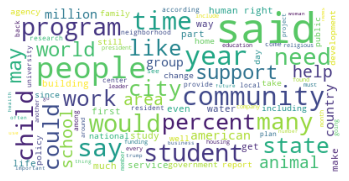

In [45]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

Tokenisation is the process of converting the continuous text into a list of words. The list of words is then converted to a matrix of integers by the process of vectorisation. Vectorisation is also called feature extraction.

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [49]:
list(cv.vocabulary_.keys())[:10]

['world',
 'last',
 'male',
 'white',
 'rhino',
 'almost',
 'certain',
 'never',
 'hoped',
 'artificial']

Visualize top N uni-grams, bi-grams & tri-grams

[Text(0, 0, 'said'),
 Text(0, 0, 'year'),
 Text(0, 0, 'people'),
 Text(0, 0, 'state'),
 Text(0, 0, 'time'),
 Text(0, 0, 'community'),
 Text(0, 0, 'right'),
 Text(0, 0, 'child'),
 Text(0, 0, 'say'),
 Text(0, 0, 'student'),
 Text(0, 0, 'percent'),
 Text(0, 0, 'program'),
 Text(0, 0, 'human'),
 Text(0, 0, 'school'),
 Text(0, 0, 'animal'),
 Text(0, 0, 'would'),
 Text(0, 0, 'health'),
 Text(0, 0, 'million'),
 Text(0, 0, 'many'),
 Text(0, 0, 'city')]

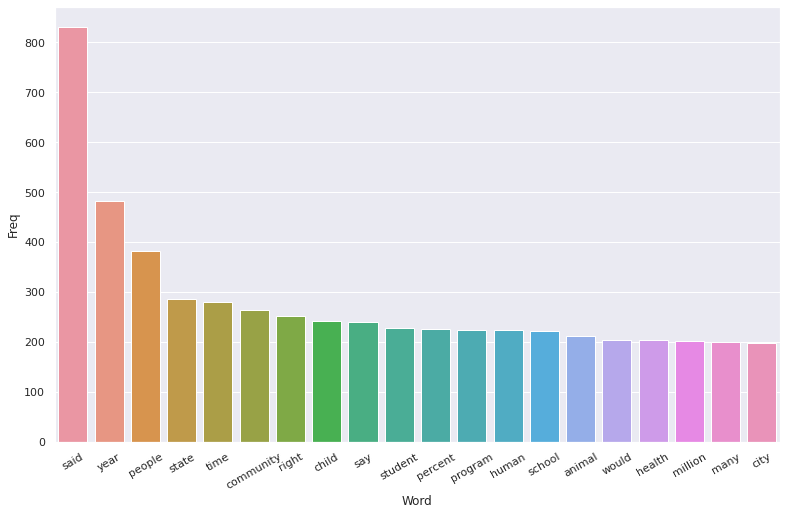

In [50]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pandas.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)


               Bi-gram  Freq
0          human right   130
1       climate change    70
2         united state    66
3           united way    48
4            last year    47
5   affordable housing    47
6             year old    39
7           child care    38
8             year ago    34
9      early childhood    33
10       mental health    32
11       united nation    32
12           slot home    31
13          low income    28
14         white house    27
15       human service    26
16           long term    26
17    health insurance    24
18      northern white    23
19         high school    23


[Text(0, 0, 'human right'),
 Text(0, 0, 'climate change'),
 Text(0, 0, 'united state'),
 Text(0, 0, 'united way'),
 Text(0, 0, 'last year'),
 Text(0, 0, 'affordable housing'),
 Text(0, 0, 'year old'),
 Text(0, 0, 'child care'),
 Text(0, 0, 'year ago'),
 Text(0, 0, 'early childhood'),
 Text(0, 0, 'mental health'),
 Text(0, 0, 'united nation'),
 Text(0, 0, 'slot home'),
 Text(0, 0, 'low income'),
 Text(0, 0, 'white house'),
 Text(0, 0, 'human service'),
 Text(0, 0, 'long term'),
 Text(0, 0, 'health insurance'),
 Text(0, 0, 'northern white'),
 Text(0, 0, 'high school')]

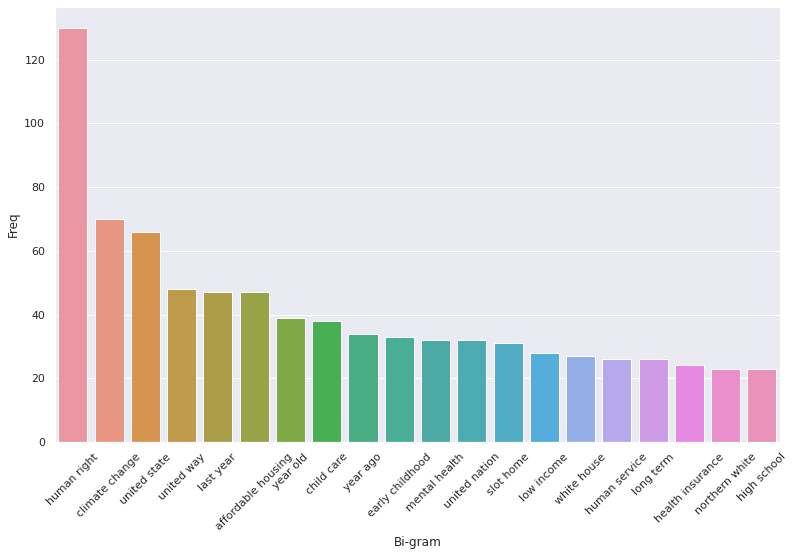

In [51]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pandas.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                      Tri-gram  Freq
0              may april march    19
1         april march february    18
2               june may april    18
3       march february january    17
4   november october september    16
5         northern white rhino    15
6     october september august    15
7                july june may    15
8         health human service    13
9    county historical society    13
10       september august july    13
11            august july june    13
12      president donald trump    12
13   february january december    12
14   january december november    12
15   december november october    12
16            latter day saint    12
17            coal fired power    12
18           fired power plant    12
19            read share story    11


[Text(0, 0, 'may april march'),
 Text(0, 0, 'april march february'),
 Text(0, 0, 'june may april'),
 Text(0, 0, 'march february january'),
 Text(0, 0, 'november october september'),
 Text(0, 0, 'northern white rhino'),
 Text(0, 0, 'october september august'),
 Text(0, 0, 'july june may'),
 Text(0, 0, 'health human service'),
 Text(0, 0, 'county historical society'),
 Text(0, 0, 'september august july'),
 Text(0, 0, 'august july june'),
 Text(0, 0, 'president donald trump'),
 Text(0, 0, 'february january december'),
 Text(0, 0, 'january december november'),
 Text(0, 0, 'december november october'),
 Text(0, 0, 'latter day saint'),
 Text(0, 0, 'coal fired power'),
 Text(0, 0, 'fired power plant'),
 Text(0, 0, 'read share story')]

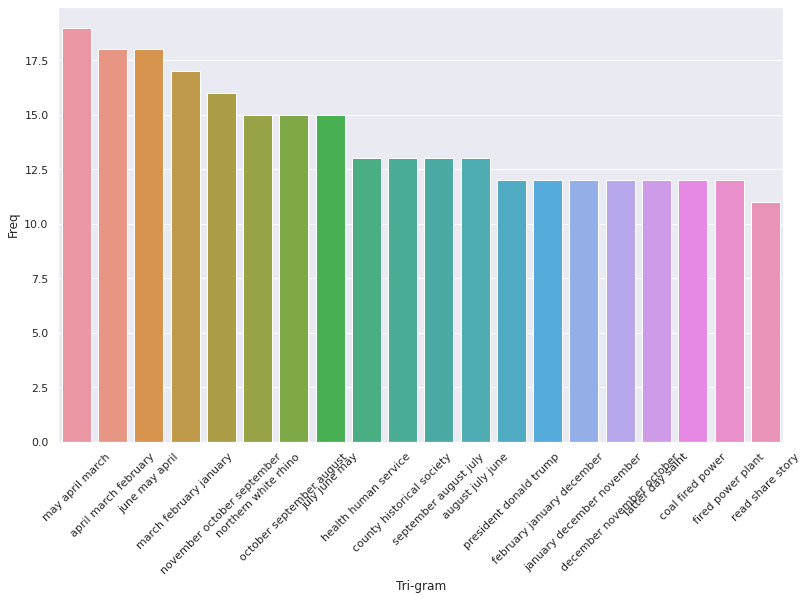

In [34]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pandas.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

Converting to a matrix of integers (TF-IDF are word frequency scores that highlight words that are more important to the context rather than those that appear frequently across documents.)

Based on the TF-IDF scores, we can extract the words with the highest scores to get the keywords for a document.

In [52]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[3]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [40]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
never mind cctv slaughterhouse need end meat dairy industry altogetherit announced week slaughterhouse england install cctv camera government move try improve animal welfare uk farm lover animal think would thrilled news instead help continue wonder earth killing animal first place question whether caught camera went vegan half year ago much shock turkish family brought kofte like meatball et borek pastry meat inside homemade kebab grandparent grew small village cyprus could rarely afford luxury meat left war torn country uk worked year low paid job began eat meat dish meat luxury would choose give luxury let start obvious argument animal welfare measure put camera slaughterhouse might mean something process raising animal kill cruel government claim camera help uphold animal welfare law apparently protective law farm animal allowed overfed leg break carrying weight kept crammed shed barely seeing shred natural daylight life live knee deep faeces remains animal died around h